In [1]:
import torch
import matplotlib.pyplot as plt
import urllib
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\round\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 11.2MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [2]:

url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)


0: 640x640 1 person, 5 sheeps, 118.7ms
Speed: 0.0ms preprocess, 118.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)


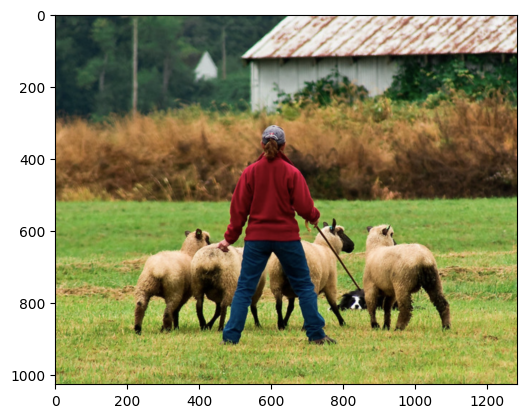

In [5]:

input_image = Image.open(filename)
input_image = input_image.convert("RGB")
plt.imshow(input_image)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640,640))
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)




In [28]:

out = output[0]
print(dir(out))
print(out.probs)
print(out.boxes)
print(out.names)
odf = out.to_df()


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_keys', 'boxes', 'cpu', 'cuda', 'keypoints', 'masks', 'names', 'new', 'numpy', 'obb', 'orig_img', 'orig_shape', 'path', 'plot', 'probs', 'save', 'save_crop', 'save_dir', 'save_txt', 'show', 'speed', 'summary', 'to', 'to_csv', 'to_df', 'to_json', 'to_xml', 'tojson', 'update', 'verbose']
None
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 0., 18., 18., 18., 18., 18.], device='cuda:0')
conf: tensor([0.9087, 0.8681, 0.8172, 0.7667, 0.5573, 0.2562], device='cuda:0')
data: tensor([[2.2533e+02, 1.9261e+02, 3.8160e+02, 5.7579e+02, 9.0869e-01, 0.0000e+00],
        

In [27]:

print(odf.iloc[0])

name                                                     person
class                                                         0
confidence                                              0.90869
box           {'x1': 225.33038, 'y1': 192.60608, 'x2': 381.5...
Name: 0, dtype: object


AttributeError: 'AxesImage' object has no attribute 'add_patch'

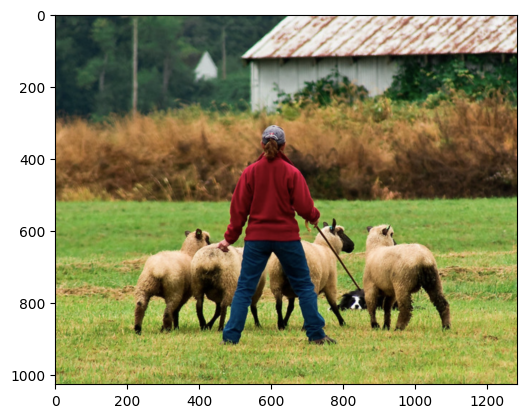

In [29]:
classes = out.names
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

from matplotlib import patches


s = input_image.size
plist = []
for t in odf.itertuples():
    box = t.box
    x1,y1,x2, y2 = (box["x1"], box["y1"], box["x2"], box["y2"])  # coords for 640x640 image
    x1,y1,x2, y2 = x1/640, y1/640, x2/640, y2/640
    h = y2-y1
    w = x2-x1
    x1 = x1*s[0]
    w = w*s[0]
    y1 = y1*s[1]
    h = h*s[1]
    plist.append(patches.Rectangle((x1,y1), width=w, height=h,  linewidth=2, edgecolor='r', facecolor='none')))



ax = plt.subplot(111)
plt.close("all")
ax = plt.imshow(input_image)
for p in plist:
    ax.add_patch(p)
plt.show()